**Load Python libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 
import plotly.express as px
from wordcloud import WordCloud
import re
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss, precision_score
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin34\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin34\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin34\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Load the dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
hotel_review = pd.read_csv('C:\\Users\\Admin34\\Desktop\\4k.2C.csv')
hotel_review["Review"] = hotel_review["Review"].str.lower()
hotel_review["Review"] = hotel_review["Review"].str.replace('\d+', '')
hotel_review.head()

,Review,Rating
0,the rooms are dirty the curtains were filthy. ...,1
1,i have to say i was nervous after reading some...,3
2,my son had to take my husband's place on the h...,3
3,"this was the rd time visiting new york, wanted...",5
4,i am an essential worker i work at sloan-kette...,5


# New Section

**Check random reviews to get a good idea of the dataset**

In [4]:
print(hotel_review["Review"][0])

the rooms are dirty the curtains were filthy. totally over priced and tourists tax is a rip off also nyc is covered in scaffolding which is totally depressing. it didn't help that trump was in town so all roads were grid locked. it was also very expensive  dollars for a tuna roll.  dollars for breakfast. i love nyc but the city is ruined by scaffolding


In [5]:
print(hotel_review["Review"][5])

worst hotel ever in every sense of the word. my husband booked it as was rated a ls  star and it was in a convenient location. what a huge disappointment! it was dirty, the rooms were ugly, filthy, small and furniture way too old. even the mirror was in the back of a small, terrible bathroom with no space to back up to see yourself as there’s a wall right behind it. as we complained they changed ours rooms twice and they were more of the same. dust, rotten curtains, bad smell, old stained carpet and no room to put your clothes. the staff was rude, and quiet frankly i could feel the bad vibes. we left and booked another hotel where we could finally enjoy our stay in nyc.


**Review count in each category**

In [6]:
X = hotel_review.groupby(by='Rating')['Review'].count()
print(X)

Rating
1     699
2     653
3     937
4    1001
5     732
Name: Review, dtype: int64


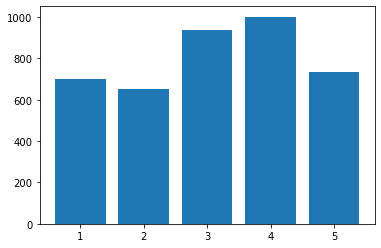

In [7]:
p = plt.bar(X.index, X.values)

**Word count plot for each rating**

In [8]:
# fig = px.histogram(hotel_review, x='Word Count', color='Rating',
#             barmode = 'overlay', nbins=50, marginal = 'box')
# fig.update_layout(title = "Word Count Distribution in Reviews by Ratings.",
#                  xaxis_title = "Word Count",
#                  yaxis_title = "No of Reviews")
# fig.show()

**Word Cloud**: To see a visual of most important words in the dataset

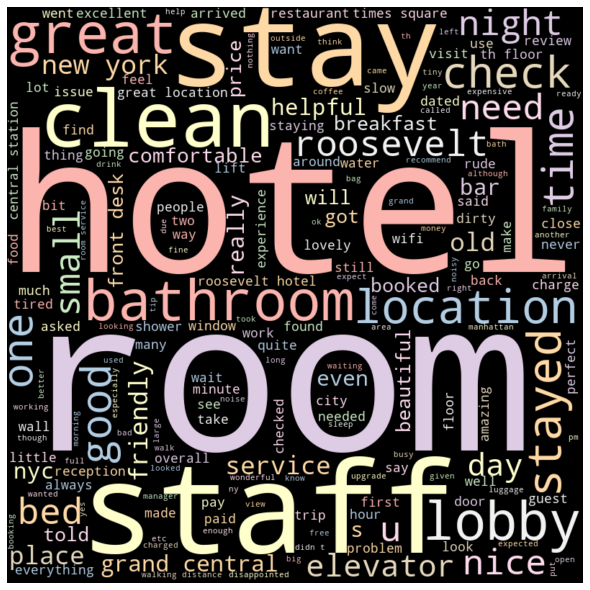

In [9]:
wordcloud = WordCloud(width = 800, height = 800, random_state=1,background_color='black', 
                      colormap='Pastel1').generate(" ".join(hotel_review["Review"]))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

**Bag of Words**

In [10]:
count_vectorizer = CountVectorizer(max_features=500, analyzer='word', stop_words = 'english')
vector_model = count_vectorizer.fit_transform(hotel_review['Review']).toarray()
print(vector_model)
print(vector_model.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(4022, 500)


In [11]:
print("Top {} the most used word by reviewers: {}".format(500, count_vectorizer.get_feature_names()))

Top 500 the most used word by reviewers: ['able', 'absolutely', 'ac', 'access', 'accommodating', 'actually', 'additional', 'adequate', 'age', 'ago', 'air', 'amazing', 'amenities', 'area', 'areas', 'arrival', 'arrive', 'arrived', 'ask', 'asked', 'attractions', 'available', 'avenue', 'average', 'away', 'awful', 'bad', 'bags', 'bar', 'basic', 'bath', 'bathroom', 'bathrooms', 'beautiful', 'bed', 'beds', 'believe', 'bell', 'best', 'better', 'big', 'birthday', 'bit', 'blocks', 'book', 'booked', 'booking', 'breakfast', 'broadway', 'broken', 'building', 'business', 'busy', 'called', 'came', 'card', 'care', 'carpet', 'center', 'central', 'change', 'changed', 'character', 'charge', 'charged', 'charges', 'charm', 'cheap', 'check', 'checked', 'checking', 'choice', 'christmas', 'city', 'classic', 'clean', 'cleaned', 'cleaning', 'close', 'closed', 'coffee', 'cold', 'come', 'comfortable', 'comfy', 'coming', 'concierge', 'conditioning', 'convenient', 'corner', 'cost', 'couldn', 'couple', 'credit', 'cu

**Extracting words**

In [12]:
data=pd.DataFrame(count_vectorizer.get_feature_names(),columns=["Words"])
data.head()

,Words
0,able
1,absolutely
2,ac
3,access
4,accommodating


**Wordclould after extractiong most meaningful words**

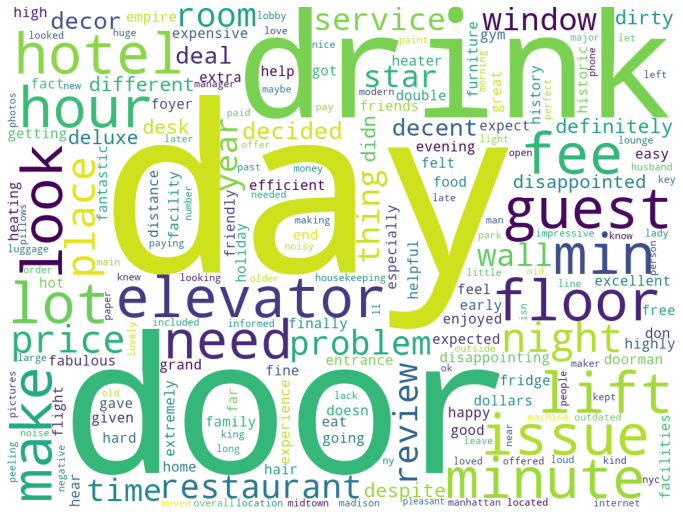

In [13]:
plt.subplots(figsize=(12,12))
wordcloud=WordCloud(background_color="white",width=1024,height=768).generate(" ".join(data.Words[100:]))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Split training and testing sets**

In [14]:
from imblearn.over_sampling import SMOTE 
X = vector_model
y = hotel_review['Rating']

sm = SMOTE(random_state = 2) 
X_smote, y_smote = sm.fit_sample(X, y) 

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 2)
print(y_train)

742     4
4125    1
868     2
936     1
1022    3
       ..
3335    3
1099    4
2514    3
3606    3
2575    2
Name: Rating, Length: 4004, dtype: int64


# **Building ML models**

**SVM**

In [15]:
from sklearn.svm import SVC
no_of_features = 5
svclassifier = SVC(kernel= 'rbf', gamma = 'auto', verbose = True, random_state=42 )
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

[LibSVM]

In [17]:
print(f'Confusion Matrix \n {confusion_matrix(y_test, y_pred)}')
print("Accuracy with P-R scores and F-score")
print(classification_report(y_test, y_pred))
print()

Confusion Matrix 
 [[142  37  12   5   7]
 [ 88  68  36   3  11]
 [ 41  28  64  35  23]
 [ 11  14  32  70  82]
 [ 14   5   7  32 134]]
Accuracy with P-R scores and F-score
              precision    recall  f1-score   support

           1       0.48      0.70      0.57       203
           2       0.45      0.33      0.38       206
           3       0.42      0.34      0.37       191
           4       0.48      0.33      0.40       209
           5       0.52      0.70      0.60       192

    accuracy                           0.48      1001
   macro avg       0.47      0.48      0.46      1001
weighted avg       0.47      0.48      0.46      1001




**Random Forest Classifier**

In [18]:
from sklearn.ensemble import RandomForestClassifier


rf_model=RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [19]:
y_pred=rf_model.predict(X_test)

In [20]:
print(f'Confusion Matrix \n {confusion_matrix(y_test, y_pred)}')
print("Accuracy with P-R scores and F-score")
print(classification_report(y_test, y_pred))
print()

Confusion Matrix 
 [[135  35  21   5   7]
 [ 49 103  34  13   7]
 [ 33  19  71  48  20]
 [  7  10  29  86  77]
 [  3   5   6  42 136]]
Accuracy with P-R scores and F-score
              precision    recall  f1-score   support

           1       0.59      0.67      0.63       203
           2       0.60      0.50      0.54       206
           3       0.44      0.37      0.40       191
           4       0.44      0.41      0.43       209
           5       0.55      0.71      0.62       192

    accuracy                           0.53      1001
   macro avg       0.53      0.53      0.52      1001
weighted avg       0.53      0.53      0.52      1001




**LSTM**

In [21]:
X = vector_model
y = hotel_review['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)
print(X_test)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [2 0 0 ... 0 0 0]]


In [22]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional


model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=20491,
                    output_dim=500,
                    input_length=500))


model.add(LSTM(100))
model.add(Dense(500, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 500)          10245500  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               240400    
_________________________________________________________________
dense (Dense)                (None, 500)               50500     
Total params: 10,536,400
Trainable params: 10,536,400
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_lstm = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data= (X_test, y_test), shuffle= False)

Epoch 1/10
101/101 [==============================] - 56s 556ms/step - loss: 2.3279 - accuracy: 0.2431 - val_loss: 1.6131 - val_accuracy: 0.2335
Epoch 2/10
101/101 [==============================] - 55s 548ms/step - loss: 1.6067 - accuracy: 0.2453 - val_loss: 1.6085 - val_accuracy: 0.2335
Epoch 3/10
101/101 [==============================] - 56s 553ms/step - loss: 1.6032 - accuracy: 0.2499 - val_loss: 1.6053 - val_accuracy: 0.2335
Epoch 4/10
101/101 [==============================] - 60s 589ms/step - loss: 1.5994 - accuracy: 0.2555 - val_loss: 1.6009 - val_accuracy: 0.2472
Epoch 5/10
101/101 [==============================] - 59s 586ms/step - loss: 1.5962 - accuracy: 0.2555 - val_loss: 1.5986 - val_accuracy: 0.2472
Epoch 6/10
101/101 [==============================] - 61s 609ms/step - loss: 1.5949 - accuracy: 0.2549 - val_loss: 1.5982 - val_accuracy: 0.2571
Epoch 7/10
101/101 [==============================] - 63s 628ms/step - loss: 1.5942 - accuracy: 0.2574 - val_loss: 1.5980 - val_ac

**Plotting training progression**

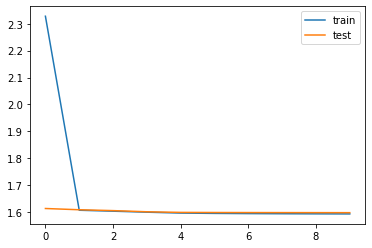

In [24]:
plt.plot(history_lstm.history['loss'], label = 'train')
plt.plot(history_lstm.history['val_loss'], label = 'test')
plt.legend()
plt.show()

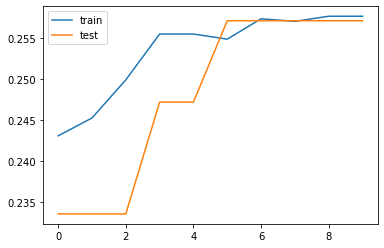

In [25]:
plt.plot(history_lstm.history['accuracy'], label = 'train')
plt.plot(history_lstm.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()